In [1]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
#this is to allow you to see the plot in the notebook
%matplotlib inline 
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
CONFIG = configparser.ConfigParser()
CONFIG.read(r'/home/jchew/local/db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## The following show gaps where gap_size > 1 minute

Trying out with 3 different time range: 12am - 6am (MIDNIGHT) , 6am - 3pm (AM) , 3pm - 12 am (PM) 

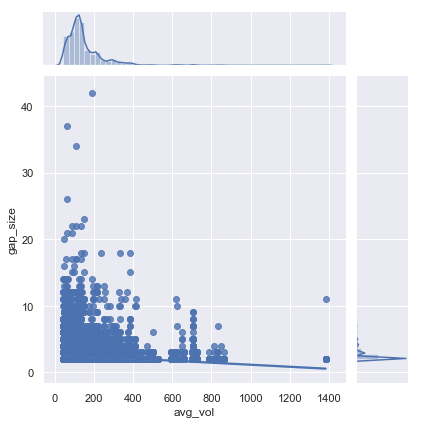

In [4]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE time_bin BETWEEN '00:00:00'::time AND '06:00:00'::time 
    AND gap_size < 50 
    AND gap_size > 0
    ''')
    # removing 1 outlier here
    data_3am_1min = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', kind='reg', data=data_3am_1min)

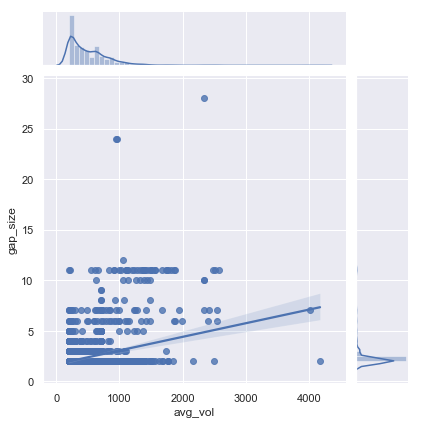

In [5]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE time_bin BETWEEN '06:00:00'::time AND '15:00:00'::time 
    AND gap_size < 50
    AND gap_size > 0
    ''')
    # removing 2 outliers here
    data_3am_1min = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', kind='reg', data=data_3am_1min)

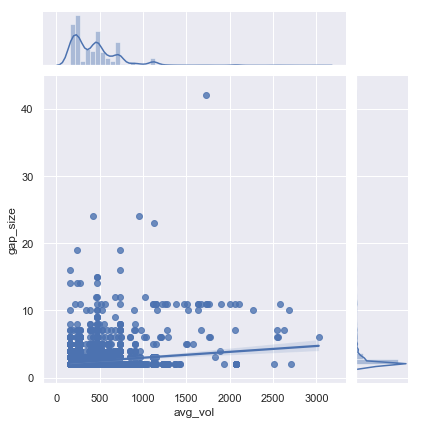

In [6]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE time_bin BETWEEN '15:00:00'::time AND '23:00:00'::time 
    AND gap_size < 100
    AND gap_size > 0
    ''')
    # removing 2 outliers here
    data_5pm_1min = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', kind='reg', data=data_5pm_1min)

# Testing out suggested volume-gap 

Based on the plots, suggesting the following gaps: \
volume [0,99): 20 mins \
volume [100,499): 10 mins \
volume [500,1499): 5 mins \
volume [1500,∞): 2 mins
Plotting them according to volume (instead of time) to investigate further.

## For volume between 0 and 99

*Note: Plot (outlier removed) followed by table (outlier not removed)*

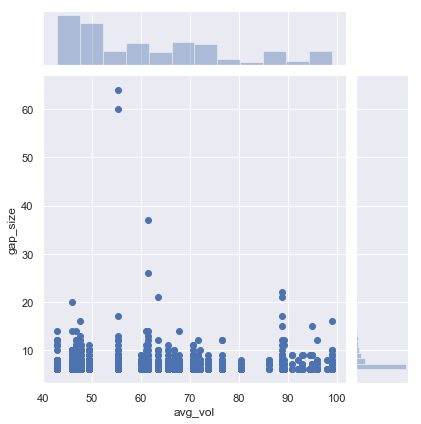

In [27]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 100
    AND gap_size < 100
    ''')
    # removing 1 outlier here
    data_100 = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_100) #, kind="kde"

In [29]:
with con:   
    sql = pg.SQL('''
    WITH sel AS (
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 100
        )
    , percentage AS (
    SELECT gap_size, COUNT(*),
    ROUND(count(*)::numeric / 20673 * 100, 3) AS pct
    FROM sel
    GROUP BY gap_size
    ORDER BY gap_size
    )
    SELECT gap_size, pct,
    100 - ( sum(pct) over (order by gap_size asc rows between unbounded preceding and current row)) AS cumu_pct_desc
    FROM percentage
    ''')
    data_pct = pandasql.read_sql(sql, con)
    
print(data_pct)

    gap_size     pct  cumu_pct_desc
0        0.0   2.003         97.997
1        2.0  58.884         39.113
2        3.0  21.845         17.268
3        4.0   9.167          8.101
4        5.0   3.933          4.168
5        6.0   1.920          2.248
6        7.0   0.996          1.252
7        8.0   0.537          0.715
8        9.0   0.276          0.439
9       10.0   0.164          0.275
10      11.0   0.082          0.193
11      12.0   0.077          0.116
12      13.0   0.015          0.101
13      14.0   0.029          0.072
14      15.0   0.010          0.062
15      16.0   0.010          0.052
16      17.0   0.010          0.042
17      20.0   0.005          0.037
18      21.0   0.010          0.027
19      22.0   0.005          0.022
20      26.0   0.005          0.017
21      37.0   0.005          0.012
22      60.0   0.005          0.007
23      64.0   0.005          0.002
24     387.0   0.005         -0.003


## For volume between 100 and 499

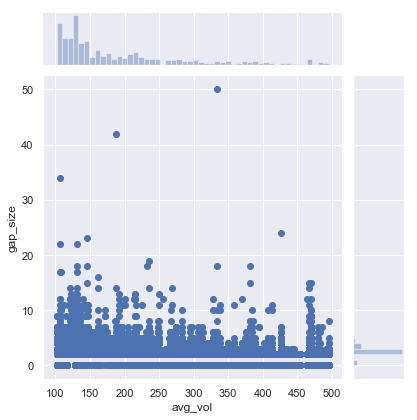

In [54]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 500
    AND avg_vol >= 100
    AND gap_size < 200
    ''')
# removing 2 outliers here
data_500 = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_500)

In [31]:
with con:   
    sql = pg.SQL('''
    WITH sel AS (
        SELECT intersection_uid, time_bin, avg_vol, gap_size 
        FROM miovision_api.volume_gap_1min
        WHERE avg_vol < 500
        AND avg_vol >= 100
        )
    , percentage AS (
    SELECT gap_size, COUNT(*),
    ROUND(count(*)::numeric / 54773 * 100, 3) AS pct
    FROM sel
    GROUP BY gap_size
    ORDER BY gap_size
    )
    SELECT gap_size, pct,
    100 - ( sum(pct) over (order by gap_size asc rows between unbounded preceding and current row)) AS cumu_pct_desc
    FROM percentage
    ''')
    data_pct = pandasql.read_sql(sql, con)
    
print(data_pct)

    gap_size     pct  cumu_pct_desc
0        0.0   7.350         92.650
1        2.0  74.911         17.739
2        3.0  12.806          4.933
3        4.0   3.047          1.886
4        5.0   0.944          0.942
5        6.0   0.398          0.544
6        7.0   0.206          0.338
7        8.0   0.071          0.267
8        9.0   0.071          0.196
9       10.0   0.042          0.154
10      11.0   0.047          0.107
11      12.0   0.038          0.069
12      13.0   0.013          0.056
13      14.0   0.013          0.043
14      15.0   0.007          0.036
15      16.0   0.002          0.034
16      17.0   0.005          0.029
17      18.0   0.009          0.020
18      19.0   0.002          0.018
19      22.0   0.004          0.014
20      23.0   0.002          0.012
21      24.0   0.002          0.010
22      34.0   0.002          0.008
23      42.0   0.002          0.006
24      50.0   0.002          0.004
25     216.0   0.002          0.002
26     667.0   0.002        

## For volume between 500 and 1499

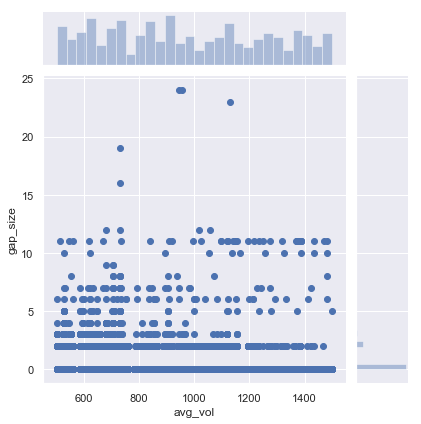

In [33]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 1500
    AND avg_vol >= 500
    AND gap_size < 150
    ''')
    # removing 2 outliers here
    data_1500 = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_1500)

In [35]:
with con:   
    sql = pg.SQL('''
    WITH sel AS (
        SELECT intersection_uid, time_bin, avg_vol, gap_size 
        FROM miovision_api.volume_gap_1min
        WHERE avg_vol < 1500
        AND avg_vol >= 500
        )
    , percentage AS (
    SELECT gap_size, COUNT(*),
    ROUND(count(*)::numeric / 23380 * 100, 3) AS pct
    FROM sel
    GROUP BY gap_size
    ORDER BY gap_size
    )
    SELECT gap_size, pct,
    100 - ( sum(pct) over (order by gap_size asc rows between unbounded preceding and current row)) AS cumu_pct_desc
    FROM percentage
    ''')
    data_pct = pandasql.read_sql(sql, con)
    
print(data_pct)

    gap_size     pct  cumu_pct_desc
0        0.0  85.372         14.628
1        2.0  12.331          2.297
2        3.0   1.245          1.052
3        4.0   0.274          0.778
4        5.0   0.188          0.590
5        6.0   0.150          0.440
6        7.0   0.128          0.312
7        8.0   0.047          0.265
8        9.0   0.013          0.252
9       10.0   0.047          0.205
10      11.0   0.158          0.047
11      12.0   0.017          0.030
12      16.0   0.004          0.026
13      19.0   0.004          0.022
14      23.0   0.004          0.018
15      24.0   0.009          0.009
16     159.0   0.004          0.005
17     189.0   0.004          0.001


## For volume > 1499

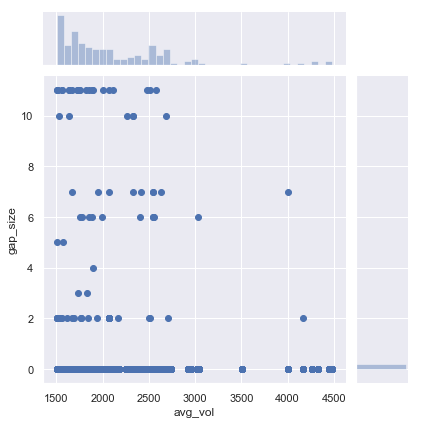

In [36]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol >= 1500
    AND gap_size < 20
    ''')
    data_others = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_others)

In [37]:
with con:   
    sql = pg.SQL('''
    WITH sel AS (
        SELECT intersection_uid, time_bin, avg_vol, gap_size 
        FROM miovision_api.volume_gap_1min
        WHERE avg_vol >= 1500
        )
    , percentage AS (
    SELECT gap_size, COUNT(*),
    ROUND(count(*)::numeric / 9221 * 100, 3) AS pct
    FROM sel
    GROUP BY gap_size
    ORDER BY gap_size
    )
    SELECT gap_size, pct,
    100 - ( sum(pct) over (order by gap_size asc rows between unbounded preceding and current row)) AS cumu_pct_desc
    FROM percentage
    ''')
    data_pct = pandasql.read_sql(sql, con)
    
print(data_pct)

    gap_size     pct  cumu_pct_desc
0        0.0  98.981          1.019
1        2.0   0.434          0.585
2        3.0   0.022          0.563
3        4.0   0.011          0.552
4        5.0   0.022          0.530
5        6.0   0.108          0.422
6        7.0   0.098          0.324
7       10.0   0.065          0.259
8       11.0   0.239          0.020
9       28.0   0.011          0.009
10      42.0   0.011         -0.002
